The data consist of today's return, today's close, and today's volume.

In [4]:
import numpy as np
X = np.load('zipped_zrxbtc.npy')
Vols = X[:-3,-1].copy()

#X

In [5]:
X[:,-1] = X[:,-1]/1000.0
X[:,-1]=np.log(X[:,-1]+1e-6)/1000
#X

In [3]:
#np.std(X[:,-1]),np.std(X[:,0])

(0.0017708445253081853, 0.002555378294901362)

Features include past 5 days return sequence, past 5 days price range, and past 5 days sum volume(log scaled).

In [6]:
XX=[]
w = 5
for i in range(int(len(X)/w)):
    #x = list(X[i*w:w*i+w,0])
    x=[sum(X[i*w:i*w+w,0])*1.0]
    x+=[(max(X[i*w:i*w+w,1])-min(X[i*w:i*w+w,1]))]
    x+=[sum(X[i*w:i*w+w,-1])*1.0]
    XX.append(x)
#XX

In [7]:
Mins = np.load('Mins_zrxbtc.npy')
Mins = Mins[:-3]

In [8]:
Close = np.load('close_zrxbtc.npy')
Close=Close[:-3]

In [9]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from hmmlearn import hmm
warnings.filterwarnings('ignore')
np.random.seed(10)
model = hmm.GaussianHMM(n_components=10, covariance_type="full", min_covar=0.0,verbose=True,n_iter=100)
model.fit(XX)  
model.monitor_  

         1      200430.1454             +nan
         2      128579.6104      -71850.5350


ConvergenceMonitor(history=[200430.1453944514, 128579.61044411211], iter=2,
          n_iter=100, tol=0.01, verbose=True)

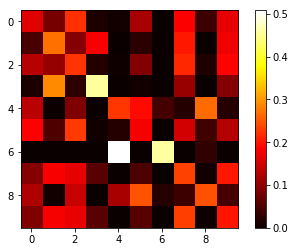

In [10]:
from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm

%matplotlib inline
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

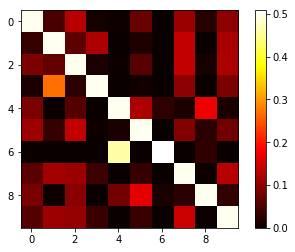

In [11]:
for s in range(model.n_components):
    p = max(0.5,np.max(model.transmat_[s]))
    if model.transmat_[s][s]>=p:
        pass
    else:
        denom = sum(model.transmat_[s])-model.transmat_[s][s]
        model.transmat_[s]/=denom
        model.transmat_[s]*=1-p
        model.transmat_[s][s] = p
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

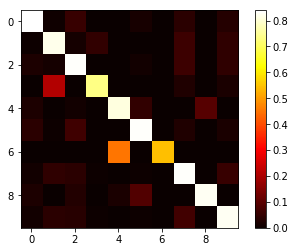

In [12]:
for s in range(model.n_components):
    model.transmat_[s] = model.transmat_[s]**2
    model.transmat_[s]/=sum(model.transmat_[s])
plt.imshow(model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()

In [13]:
ZZ = model.predict(XX)

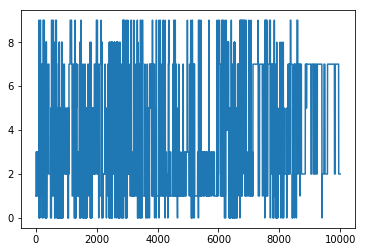

In [14]:
plt.plot(ZZ)

In [15]:
len(XX),len(ZZ)

(9999, 9999)

In [16]:
len(Mins),len(Close)

(49995, 49995)

In [17]:
Z=[]
for i in ZZ:
    Z+=[i]*w
print len(Z)
Z = np.array(Z)

49995


In [18]:

print("Transition matrix")
print(model.transmat_)
print()
from matplotlib import cm
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()



Transition matrix
[[8.39502033e-01 8.21289351e-03 5.88525902e-02 2.49888458e-04
  6.28115933e-05 1.76006945e-02 6.56443700e-07 4.01927477e-02
  1.77843127e-03 3.35472531e-02]
 [3.74358725e-03 8.19895828e-01 1.34652127e-02 5.09587898e-02
  2.89712411e-07 8.80746415e-04 1.73228865e-10 6.34401871e-02
  4.90871723e-06 4.76104504e-02]
 [2.45697243e-02 1.56760108e-02 8.33458173e-01 4.93387839e-04
  2.71858340e-05 1.16696665e-02 4.88201587e-08 6.46364192e-02
  3.80975970e-04 4.90884072e-02]
 [5.36111922e-04 2.11561360e-01 1.82176423e-03 7.34850606e-01
  2.59164642e-08 1.44079934e-04 3.63597433e-14 2.88303700e-02
  8.84351686e-08 2.22555937e-02]
 [2.46164711e-02 1.06872025e-05 1.06899801e-02 1.48121600e-08
  8.13130523e-01 5.08102394e-02 2.80728774e-03 6.43591720e-04
  9.67508402e-02 5.40364705e-04]
 [4.25431858e-02 3.55639863e-03 6.56373399e-02 7.01890924e-05
  5.36625853e-04 8.35745014e-01 4.77437763e-08 2.87492393e-02
  2.07689291e-03 2.10850670e-02]
 [4.54876334e-07 1.12085416e-15 3.455069

In [21]:
Ret = X[:,0]
log_Ret = np.log(Ret+1.0)
def score_plot(Mins,Close,Vols,Ret,Z,n_comp,th = 0.2,fee=0.005):
    end = []
    Seg = []
    plt.figure()
    for i in range(n_comp):
        cur = [0]
        seg = 0
        flag= False
        for j in range(len(Z)):
            if i == Z[j]:
                if not flag:
                    seg+=1
                    flag = True
                cur.append(cur[-1]+Ret[j])
            else:
                if flag:
                    flag=False
                cur.append(cur[-1])
        end.append(cur[-1])
        Seg.append(seg)
        plt.plot(Mins,cur[1:],label='Z='+str(i)+' '+str(cur[-1]))
    plt.legend(loc='upper left')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Log Return')
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(20,6))
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('eth-btc', color=color)
    ax1.plot(Mins, Close, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
    ax2.plot(Mins, Vols, color=color)
    ax2.set_ylim(0,1000)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout() 
    score_up = 0
    score_down = 0
    score_none = 0
    tseg = sum(Seg)
    #fee=0.005
    for i in range(n_comp):

        if end[i]<th*max(end) and end[i]>th*min(end):
            score_none+=end[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'bo',markersize=1)
        elif end[i]>=th*max(end):
            score_up+=end[i]-fee*Seg[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'ro',markersize=3)
        else:
            score_down+=abs(end[i])-fee*Seg[i]
            ax1.plot(Mins[Z==i],Close[Z==i],'go',markersize=3)
    score = score_up+score_down-abs(score_none)
    print 'Score:'+str(score)
    return score,Seg

Score:7.616662238656394


(7.616662238656394, [124, 100, 111, 42, 26, 143, 7, 93, 50, 60])

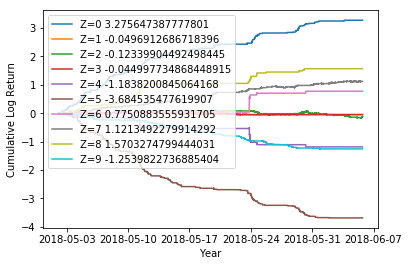

<Figure size 432x288 with 0 Axes>

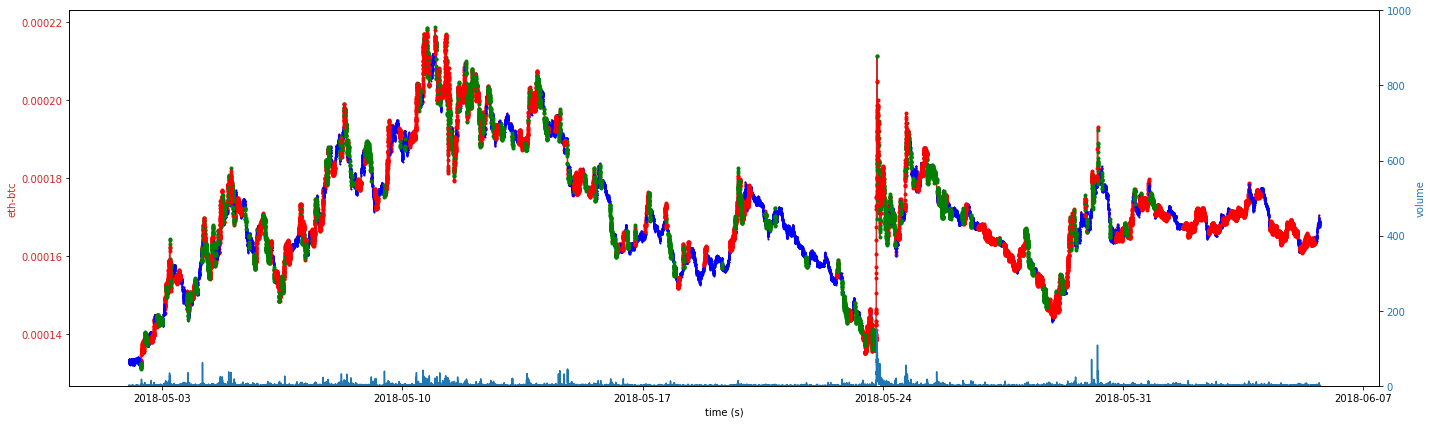

In [24]:
score_plot(Mins,Close,Vols,Ret,Z,model.n_components,th=0.2,fee=0.01)

### Results:
#### p threshold = 0.9:  Score = 5.972
####            = 0.7:  Score = 6.923
####            = 0.5:  Score = 7.617
####            = 0.4:  Score = 7.723
####            = 0.3:  Score = 5.699